Code below solves picture sequence algorithmically by looking at:

1. characteristics of the location
 a. what's changed
 
2. characteristics of the image
 a. meta data including image angle, ambient light
 
3. transitive relationships
 a. if image 1 comes before image 2 and image 2 comes before image 3, then image 1 comes before image 3.
 
It implements these relationships using concepts from "Learning to Compare Image Patches via Convolutional Neural Networks" by Zagoruyko and Komodakis (2015). Specifically:

1. it creates x channels:

2. it creates y streams:

It then creates x00,000 traning sequences

1. Each picture becomes 6 pictures: original, horizontal flip, vertical flip, +90, +180, +270. So, each sequence becomes 6 sequences. 

 - 5 pics in 100 seq = 500 -> 5 pics in 600 seq = 3,000

2. Each picture becomes 4 patch sequences. So, each batch of 5 becomes 20: 0,1; 0,2; 0,3; 0,4; 1,0; 1,2...

 - 3,000 pics * 4 seq / picture = 12,000 seqs

2. Each of t


# initial analysis

source: https://www.kaggle.com/bkamphaus/draper-satellite-image-chronology/exploratory-image-analysis

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import glob, os
from __future__ import division
from PIL import Image
from PIL import ImageFilter
import time
import multiprocessing
import random; random.seed(2016);
import cv2
import re


# Read in files

In [5]:
# create list containing all file names
smjpegs = [f for f in glob.glob("./input/train_sm/*.jpeg")]
 
set4 = [smj for smj in smjpegs if "set4_" in smj]
set79 = [smj for smj in smjpegs if "set79_" in smj]
set175 = [smj for smj in smjpegs if "set175_" in smj]

#when processing:
# 1. ensure all images are same size. so, get all sizes, find smallest (> threshold), crop others from center
# 2. for handling, create obj for each. store in list. i.e.,:
#   set144 = [MSImage(plt.imread(smj)) for smj in smjpegs if "set144" in smj]
#   then access individuals by "set144[0].image, .matrix, .to_flat_img, to_flat_img

In [104]:
print(smjpegs[0])

./input/train_sm/set107_1.jpeg


(350, 1370, 274)
[[109, 255, 0], [109, 255, 0], [109, 255, 0], [109, 255, 0], [109, 255, 0]]


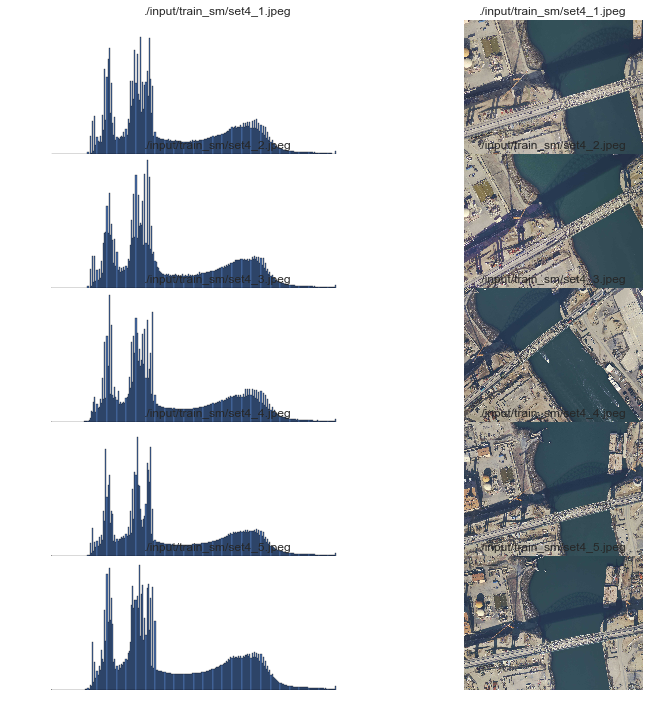

In [72]:
sample_sub = pd.read_csv('sample_submission.csv')

train_files = pd.DataFrame([[f,
                             f.split("/")[3].split(".")[0].split("_")[0],
                             f.split("/")[3].split(".")[0].split("_")[1]] for f in glob.glob("./input/train_sm/*.jpeg")])

train_files.columns = ['path', 'group', 'pic_no']

test_files = pd.DataFrame([[f,
                            f.split("/")[3].split(".")[0].split("_")[0],
                            f.split("/")[3].split(".")[0].split("_")[1]] for f in glob.glob("./input/test_sm/*.jpeg")])

test_files.columns = ['path', 'group', 'pic_no']

print(len(train_files.group.unique()), len(test_files.group.unique()))

train_images = train_files[train_files["group"]=='set4']
train_images = train_images.sort_values(by=["pic_no"], ascending=[1]).reset_index(drop=True)

plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.subplots_adjust(wspace=0, hspace=0)

i_ = 0
a = []
for l in train_images.path:
    
    im = cv2.imread(l) # grab each image
    
    plt.subplot(5, 2, i_+1).set_title(l)
    plt.hist(im.ravel(),256,[0,256]); plt.axis('off') # unravel and plot hist of values
    
    a.append([int(im.mean()),im.max(),im.min()]) # save off the mean, max and min values
    
    plt.subplot(5, 2, i_+2).set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    
    i_ += 2
    
print(a)

# Explore the data

((2329, 3099, 3), (2329, 3099, 3))
((2329, 3100, 3), (2329, 3099, 3))
((2329, 3099, 3), (2329, 3099, 3))
((2329, 3100, 3), (2329, 3100, 3))


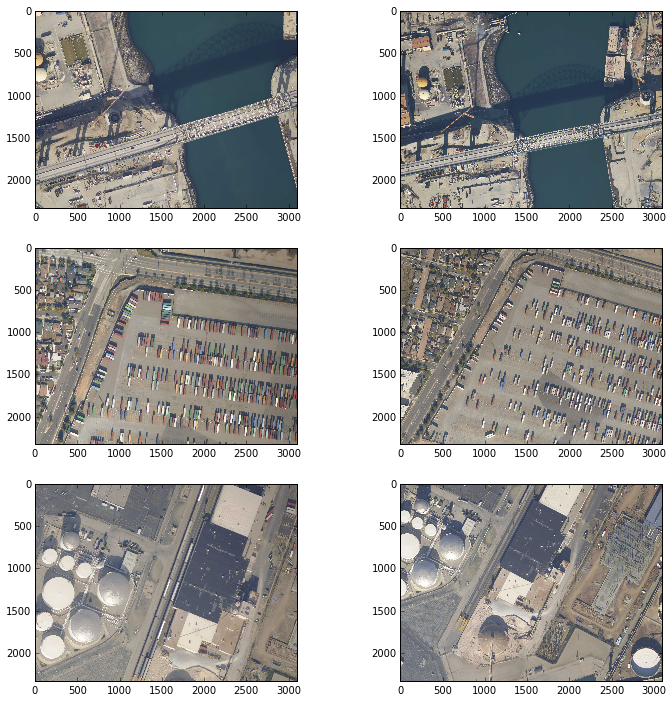

In [36]:
s4_1 = plt.imread(set4[0])
s4_5 = plt.imread(set4[4])
s79_1 = plt.imread(set79[0])
s79_5 = plt.imread(set79[4])
s175_1 = plt.imread(set175[0])
s175_5 = plt.imread(set175[4])

plt.figure(figsize=(12, 12))
plt.subplot(3,2,1); plt.imshow(s4_1)
plt.subplot(3,2,2); plt.imshow(s4_5)
plt.subplot(3,2,3); plt.imshow(s79_1)
plt.subplot(3,2,4); plt.imshow(s79_5)
plt.subplot(3,2,5); plt.imshow(s175_1)
plt.subplot(3,2,6); plt.imshow(s175_5)

print(np.shape(s4_1), np.shape(s4_5))
print(np.shape(s79_1), np.shape(s79_5))
s79_1 = s79_1[:,0:3099,:]
print(np.shape(s79_1), np.shape(s79_5))
print(np.shape(s175_1), np.shape(s175_5))


Naive red band subtraction on unregistered images:

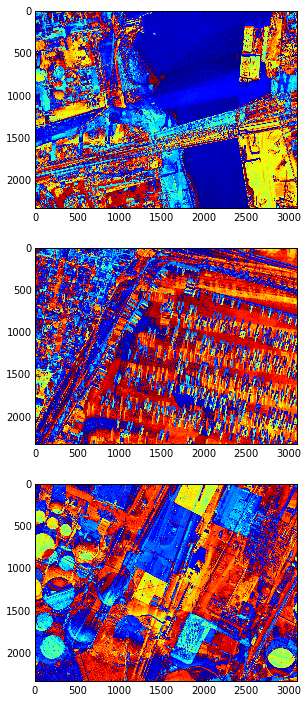

In [37]:
plt.figure(figsize=(12, 12))
plt.subplot(3,1,1); plt.imshow(s4_1[:,:,2] - s4_5[:,:,1])
plt.subplot(3,1,2); plt.imshow(s79_1[:,:,2] - s79_5[:,:,1])
plt.subplot(3,1,3); plt.imshow(s175_1[:,:,2] - s175_5[:,:,1])

For any image specific classification, clustering, etc. transforms we'll want to 
collapse spatial dimensions so that we have a matrix of pixels by color channels.

In [39]:
dims = s4_1.shape; s4_1_mat = np.reshape(s4_1, (dims[0] * dims[1], dims[2]))
dims = s4_5.shape; s4_5_mat = np.reshape(s4_5, (dims[0] * dims[1], dims[2]))

dims = s79_1.shape; s79_1_mat = np.reshape(s79_1, (dims[0] * dims[1], dims[2]))
dims = s79_5.shape; s79_5_mat = np.reshape(s79_5, (dims[0] * dims[1], dims[2]))

dims = s175_1.shape; s175_1_mat = np.reshape(s175_1, (dims[0] * dims[1], dims[2]))
dims = s175_5.shape; s175_5_mat = np.reshape(s175_5, (dims[0] * dims[1], dims[2]))

print(np.shape(s4_1_mat))
# recall that pixel matrix is the RGB for each pixel position
print(s4_1_mat[0:3,])

(7217571, 3)
[[186 157 123]
 [186 157 123]
 [185 156 122]]


What if we constrain image to five colors using kmeans (i.e., clustering colors around five means, then using cluster labels as primary colors). 

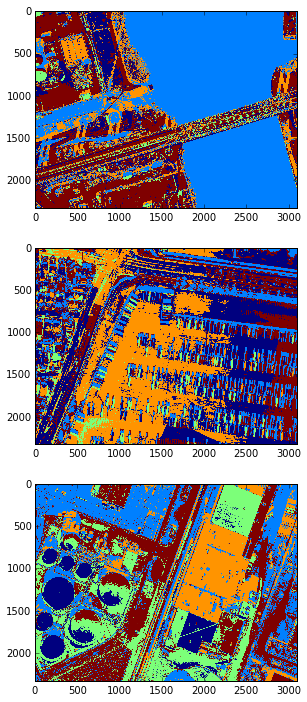

In [41]:
# simple k means clustering
from sklearn import cluster
kmeans = cluster.KMeans(5)

plt.figure(figsize=(12, 12))
plt.subplot(3,1,1)
clustered = kmeans.fit_predict(s4_1_mat); dims = np.shape(s4_1)
clustered_img = np.reshape(clustered, (dims[0], dims[1]))
plt.imshow(clustered_img)

plt.subplot(3,1,2)
clustered = kmeans.fit_predict(s79_1_mat); dims = np.shape(s79_1)
clustered_img = np.reshape(clustered, (dims[0], dims[1]))
plt.imshow(clustered_img)

plt.subplot(3,1,3)
clustered = kmeans.fit_predict(s175_1_mat); dims = np.shape(s175_1)
clustered_img = np.reshape(clustered, (dims[0], dims[1]))
plt.imshow(clustered_img)


That takes too long. Let's take out color by normalizing the color vectors for each image. Here normalization is dividing each of R-G-B by it's max value in the image. So, let's first get a "before" snapshot (histogram) of the color distribution of each image.

In [42]:
ind0, ind1, ind2, ind3 = [np.where(clustered == x)[0] for x in [0, 1, 2, 3]]

This code doesn't run on the server.

```python
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot_vals = [('r', 'o', ind0),
             ('b', '^', ind1),
             ('g', '8', ind2),
             ('m', '*', ind3)]

for c, m, ind in plot_vals:
    xs = pixel_matrix[ind, 0]
    ys = pixel_matrix[ind, 1]
    zs = pixel_matrix[ind, 2]
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('Blue channel')
ax.set_ylabel('green channel')
ax.set_zlabel('Red channel')
```

Class below stores dims and formats for images for ease of use. Specifically, it: 1. takes an image, 2. stores it, 3. stores its dims, 4. stores its "mat" which flattens the first two dimensions into a long array of height 1.

In [44]:
class MSImage():
    """Lightweight wrapper for handling image to matrix transforms. No setters,
    main point of class is to remember image dimensions despite transforms."""
    
    def __init__(self, img):
        """Assume color channel interleave that holds true for this set."""
        self.img = img
        self.dims = np.shape(img)
        self.mat = np.reshape(img, (self.dims[0] * self.dims[1], self.dims[2]))

    @property
    def matrix(self):
        return self.mat
        
    @property
    def image(self):
        return self.img
    
    def to_flat_img(self, derived):
        """"Use dims property to reshape a derived matrix back into image form when
        derived image would only have one band."""
        return np.reshape(derived, (self.dims[0], self.dims[1]))
    
    def to_matched_img(self, derived):
        """"Use dims property to reshape a derived matrix back into image form."""
        return np.reshape(derived, (self.dims[0], self.dims[1], self.dims[2]))

In [45]:
s4_1_ms = MSImage(s4_1)
s79_1_ms = MSImage(s79_1)
s175_1_ms = MSImage(s175_1)

# Brightness Normalization

Brightness Normalization is preprocessing strategy you can apply prior to using strategies to identify materials in a scene, if you want your matching algorithm to be robust across variations in illumination. It divides each color in each picture by its max for that picture reducing the overall variability between images taken under different lighting conditions by re-stating the pixels in terms of the max.

So, it's a little bit like, but less heavy handed, the clustering done earlier. however, here we're not forcing it down to 5 colors, we're just taking out a lot of noise. 

See [Wu's paper](https://pantherfile.uwm.edu/cswu/www/my%20publications/2004_RSE.pdf).

In [46]:
def bnormalize(mat):
    """much faster brightness normalization, since it's all vectorized"""

    bnorm = np.zeros_like(mat, dtype=np.float32)
    maxes = np.max(mat, axis=1)
    
    bnorm = mat / np.vstack((maxes, maxes, maxes)).T
    
    return bnorm

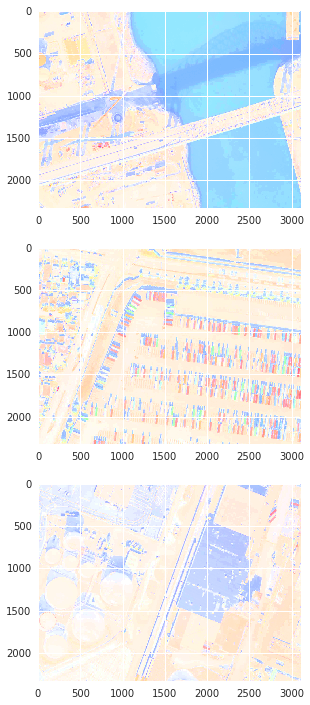

In [47]:
plt.figure(figsize=(12, 12))

plt.subplot(3,1,1)
s4_1_nrm = bnormalize(s4_1_ms.matrix)
plt.imshow(s4_1_ms.to_matched_img(s4_1_nrm))

plt.subplot(3,1,2)
s79_1_nrm = bnormalize(s79_1_ms.matrix)
plt.imshow(s79_1_ms.to_matched_img(s79_1_nrm))

plt.subplot(3,1,3)
s175_1_nrm = bnormalize(s175_1_ms.matrix)
plt.imshow(s175_1_ms.to_matched_img(s175_1_nrm))


Let's see the effect on color distributions by looking at before and after color histograms for image 2 above. The range of variation w/in R, G, B bands has been significantly reduced. 

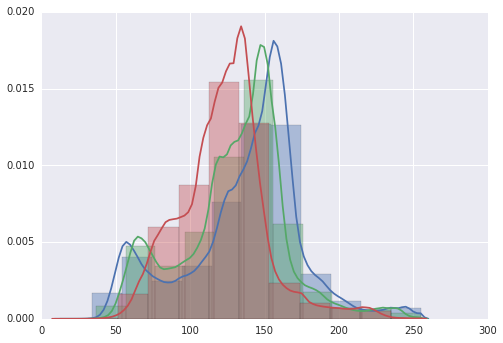

In [49]:
import seaborn as sns

sns.distplot(s79_1_mat[:,0], bins=12)
sns.distplot(s79_1_mat[:,1], bins=12)
sns.distplot(s79_1_mat[:,2], bins=12)

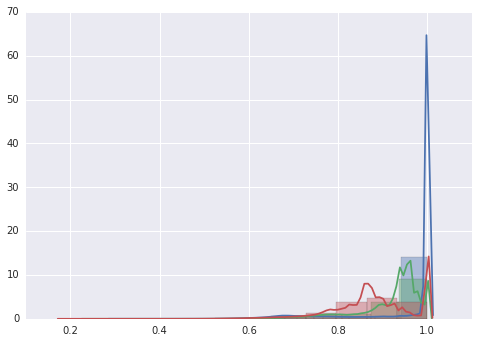

In [52]:
sns.distplot(s79_1_nrm[:,0], bins=12)
sns.distplot(s79_1_nrm[:,1], bins=12)
sns.distplot(s79_1_nrm[:,2], bins=12)

# Rudimentary Transforms, Edge Detection, Texture

In [60]:
import skimage
from skimage.feature import greycomatrix, greycoprops
from skimage.filters import sobel
from skimage.filters import sobel_h

# Sobel Edge Detection

A Sobel filter is one means of getting a basic edge magnitude/gradient image. Can be useful to
threshold and find prominent linear features, etc. Several other similar filters in skimage.filters
are also good edge detectors: `roberts`, `scharr`, etc. and you can control direction, i.e. use
an anisotropic version.

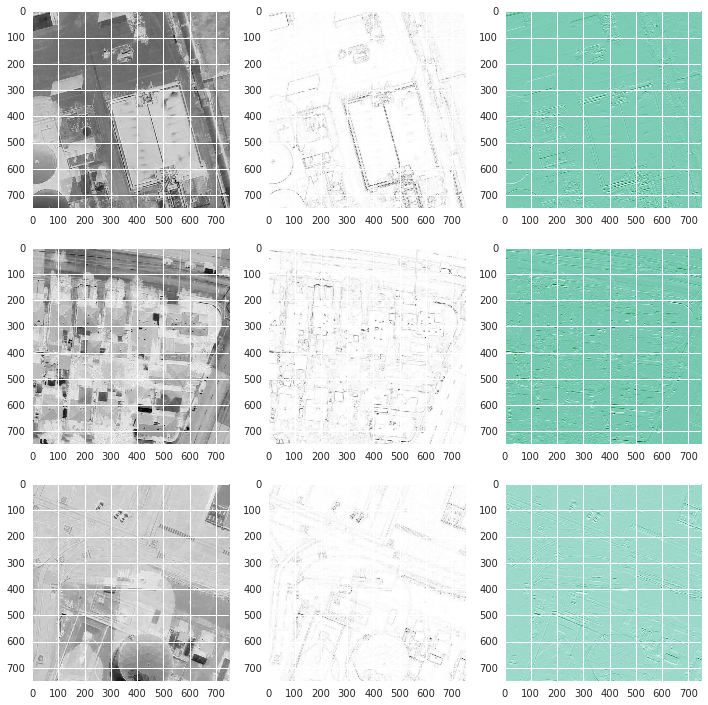

In [62]:
# a sobel filter is a basic way to get an edge magnitude/gradient image
plt.figure(figsize=(12, 12))

plt.subplot(3,3,1)
plt.imshow(s4_1[:750,:750,2])
plt.subplot(3,3,2)
plt.imshow(sobel(s4_1[:750,:750,2]))
plt.subplot(3,3,3)
plt.imshow(sobel_h(s4_1[:750,:750,2]), cmap="BuGn")

plt.subplot(3,3,4)
plt.imshow(s79_1[:750,:750,2])
plt.subplot(3,3,5)
plt.imshow(sobel(s79_1[:750,:750,2]))
plt.subplot(3,3,6)
plt.imshow(sobel_h(s79_1[:750,:750,2]), cmap="BuGn")

plt.subplot(3,3,7)
plt.imshow(s175_1[:750,:750,2])
plt.subplot(3,3,8)
plt.imshow(sobel(s175_1[:750,:750,2]))
plt.subplot(3,3,9)
plt.imshow(sobel_h(s175_1[:750,:750,2]), cmap="BuGn")


# PCA transform

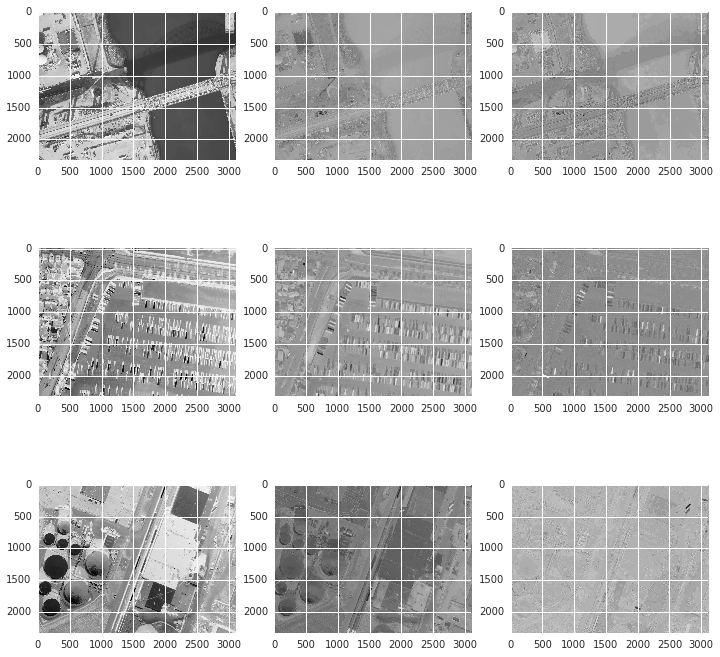

In [64]:
from sklearn.decomposition import PCA
pca = PCA(3)

plt.figure(figsize=(12, 12))

pca.fit(s4_1_ms.matrix)
s4_1_pca = pca.transform(s4_1_ms.matrix)
s4_1_pca_img = s4_1_ms.to_matched_img(s4_1_pca)

plt.subplot(3,3,1)
plt.imshow(s4_1_pca_img[:,:,0])
plt.subplot(3,3,2)
plt.imshow(s4_1_pca_img[:,:,1])
plt.subplot(3,3,3)
plt.imshow(s4_1_pca_img[:,:,2])

pca.fit(s79_1_ms.matrix)
s79_1_pca = pca.transform(s79_1_ms.matrix)
s79_1_pca_img = s79_1_ms.to_matched_img(s79_1_pca)

plt.subplot(3,3,4)
plt.imshow(s79_1_pca_img[:,:,0])
plt.subplot(3,3,5)
plt.imshow(s79_1_pca_img[:,:,1])
plt.subplot(3,3,6)
plt.imshow(s79_1_pca_img[:,:,2])

pca.fit(s175_1_ms.matrix)
s175_1_pca = pca.transform(s175_1_ms.matrix)
s175_1_pca_img = s175_1_ms.to_matched_img(s175_1_pca)

plt.subplot(3,3,7)
plt.imshow(s175_1_pca_img[:,:,0])
plt.subplot(3,3,8)
plt.imshow(s175_1_pca_img[:,:,1])
plt.subplot(3,3,9)
plt.imshow(s175_1_pca_img[:,:,2])

# pairing function

We want to traverse multiple lists of images and construct all naive before/after pairs.

* Note there are actually more before/after pairs in this space, but this blows up quickly, at
  least for little Kaggle notebooks.

In [88]:
def get_pairs(imgls):
    pairl = []
    for imgl in imgls:
        pairl += [(a,b) for a,b in zip(imgl[:-1], imgl[1:])]
    return pairl
            
paired = get_pairs([set35, set79, set285, set175])

NameError: name 'set35' is not defined

In [ ]:
# Let's just start with a dorky example.
rev_pairs = [(imgb, imga) for imga, imgb in paired]

In [ ]:
img_a, img_b = rev_pairs[0]
concat_img = np.vstack((img_a, img_b))
print(np.shape(concat_img))
plt.imshow(concat_img)

In [ ]:
import random

def concatter(imgpairs):
    for a, b in imgpairs:
        yield np.vstack((a, b))

concats = [cimg for cimg in concatter(paired + rev_pairs)]
random.shuffle(concats)

# Oops!

Shuffled before supplying labels elsewhere about whether it's forward or backward comparison.

Going to have to leave this for tonight anyways.

In [ ]:
plt.figure(figsize=(10,15))
plt.subplot(321)
plt.imshow(concats[0])
plt.subplot(322)
plt.imshow(concats[1])
plt.subplot(323)
plt.imshow(concats[2])
plt.subplot(324)
plt.imshow(concats[3])
plt.subplot(325)
plt.imshow(concats[4])
plt.subplot(326)
plt.imshow(concats[5])
plt.show()

In [ ]:
# Need to simplify or build up next block from convnet template.

```python
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D

# Need to add dropouts
model = Sequential()

# conv layer 1
model.add(Convolution2D(50,1,2,2))
model.add(Activation('relu'))

# conv layer 2
model.add(Convolution2D(50, 32, 2, 2))
model.add(Activation('relu')) 
model.add(MaxPooling2D(poolsize=(2,2)))

# conv layer 3
model.add(Convolution2D(50, 50, 2, 2))
model.add(Activation('relu'))
model.add(MaxPooling2D(poolsize=(2,2)))

# feed to fully connected 
model.add(Flatten())

# first fully connected
model.add(Dense(1000, 128, init='glorot_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# next fully connected
model.add(Dense(128, 64, init='glorot_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# last fully connected which outputs comparison result
model.add(Dense(64, 1, init='glorot_uniform'))
model.add(Activation('sigmoid'))

# compile model
# model.compile(loss='binary_crossentropy', optimizer="rmsprop")
```

# stitching images together

## create image / address matrix

source: https://www.kaggle.com/the1owl/draper-satellite-image-chronology/stitch-and-predict/notebook

## finding edges

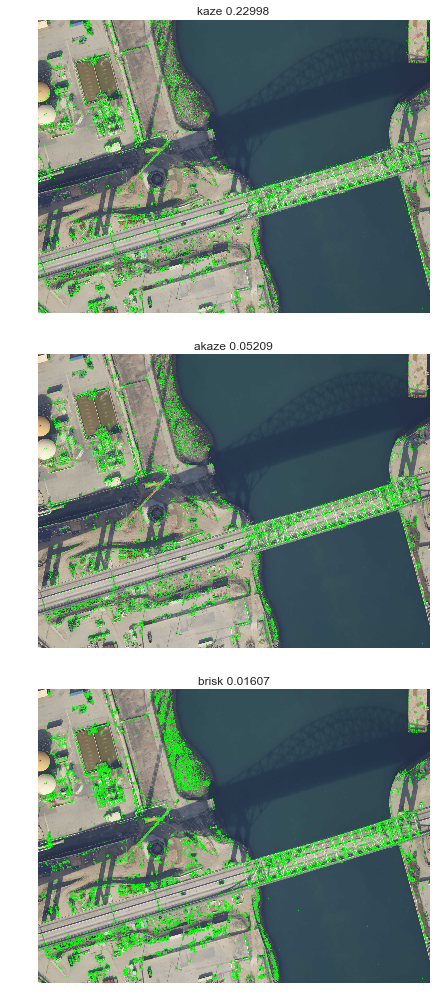

In [80]:
# instantiate kaze, akaze and brisk local feature marking class objects
kaze = cv2.KAZE_create()
akaze = cv2.AKAZE_create()
brisk = cv2.BRISK_create()

plt.rcParams['figure.figsize'] = (7.0, 18.0)
plt.subplots_adjust(wspace=0, hspace=0)

i = 0
for detector in [kaze, akaze, brisk]: #loading feature marking objects into list
    
    start_time = time.time()
    
    # load image and convert to grayscale
    im = cv2.imread(train_images.path[0])
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    (kps, descs) = detector.detectAndCompute(gray, None) # detect finds keypoints. Compute is calcs descs.
    
    cv2.drawKeypoints(im, kps, im, (0, 255, 0))
    
    plt.subplot(3, 1, i+1).set_title(list(['kaze','akaze','brisk'])[i] + " " + str(round(((time.time() - start_time)/60),5)))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    
    i+=1

## pairing images

## resizing, stitching

In [82]:
brisk = cv2.BRISK_create()
dm = cv2.DescriptorMatcher_create("BruteForce")
"""DescriptorMatcher is an abstract base class for matching keypoint descriptors. It has two 
groups of match methods: for matching descriptors of an image with another image or with an 
image set. For each, it uses match(), radiusmatch() and knnmatch() functions"""

def c_resize(img, ratio):
    wh = (int(img.shape[1] * ratio), int(img.shape[0] * ratio))
    img = cv2.resize(img, wh, interpolation = cv2.INTER_AREA)
    return img
    
def im_stitcher(imp1, imp2, imsr = 1.0, withTransparency=False):
    img1 = cv2.imread(imp1, 0)
    img2 = cv2.imread(imp2, 0)
    
    if imsr < 1.0:
        img1 = c_resize(img1,imsr); img2 = c_resize(img2,imsr)
        
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    
    kp1, des1 = brisk.detectAndCompute(img1,None)
    kp2, des2 = brisk.detectAndCompute(img2,None)
    
    matches = dm.knnMatch(des1,des2, 2)
    
    matches_ = []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * 0.75:
            matches_.append((m[0].trainIdx, m[0].queryIdx))
            
    kp1_ = np.float32([kp1[m[1]].pt for m in matches_]).reshape(-1,1,2)
    kp2_ = np.float32([kp2[m[0]].pt for m in matches_]).reshape(-1,1,2)
    
    H, mask = cv2.findHomography(kp2_,kp1_, cv2.RANSAC, 4.0)
    
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    
    pts2_ = cv2.perspectiveTransform(pts2, H)
    
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
    
    img1 = cv2.imread(imp1)
    img2 = cv2.imread(imp2)
    
    if imsr < 1.0:
        img1 = c_resize(img1,imsr); img2 = c_resize(img2,imsr)
        
    im = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    
    if withTransparency == True:
        h3,w3 = im.shape[:2]
        bim = np.zeros((h3,w3,3), np.uint8)
        bim[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
        im = cv2.addWeighted(im,1.0,bim,0.9,0)
    else:
        im[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    return im

(-0.5, 2157.5, 1670.5, -0.5)

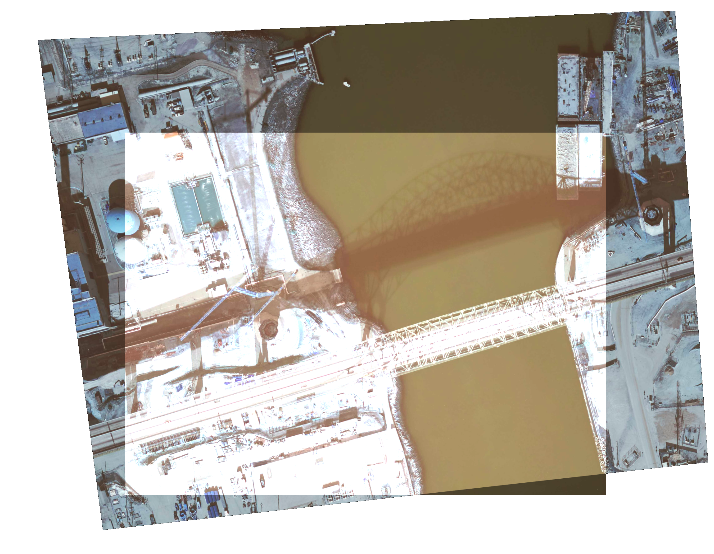

In [83]:
img = im_stitcher(train_images.path[0], train_images.path[4], 0.5, True)

plt.rcParams['figure.figsize'] = (12.0, 12.0)
img[np.where((img < [20,20,20]).all(axis = 2))] = [255,255,255]
plt.imshow(img); plt.axis('off')

(-0.5, 2335.5, 2107.5, -0.5)

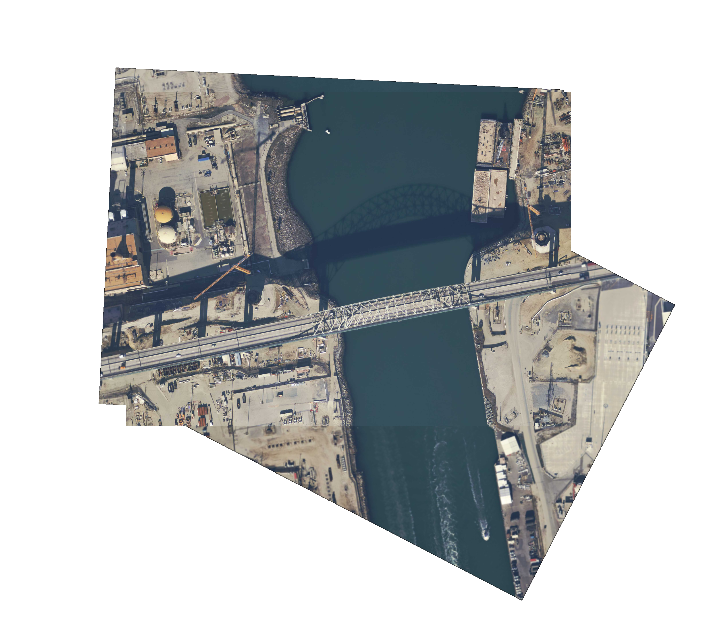

In [84]:
img = cv2.imread(train_images.path[0])

cv2.imwrite('panoramic.jpeg',img)

plt.rcParams['figure.figsize'] = (12.0, 12.0)

for i in range(1,5):
    img = im_stitcher(train_images.path[i], 'panoramic.jpeg', 0.5, False)
    cv2.imwrite('panoramic.jpeg',img)
    
img[np.where((img < [20,20,20]).all(axis = 2))] = [255,255,255]

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')

## problem: you don't want union, you want 1. each pared down to its intersection, 2. homography (rotation, etc.) for each, 3. prior sequence predictions (if a < b and b < c then a < c). 

Functions below: 1. take set id, find images then feed them two at a time to a..., 2. function that finds image features, maps features between images, then warps second image to, as near as possible, match perepctive of first. Result is "apples to apples" comparison of image content. 

In [133]:
# Any results you write to the current directory are saved as output.

def im_align_brisk(imp1, imp2, nf=10000):
    """
    :param imp1: image1 file path
    :param imp2: image2 file path
    :param nf: max number of ORB key points
    :return:  transformed image2, so that it can be aligned with image1
    """
    img1 = cv2.imread(imp1, 0)
    img2 = cv2.imread(imp2, 0)
    h2, w2 = img2.shape[:2]
    
    brisk = cv2.BRISK_create()
    #orb = cv2.ORB_create(nfeatures=nf, WTA_K=2)
    # this is causing a fault on orb.detect
    
    """ORB: alternative to proprietary SIFT or SURF. ORB fuses FAST keypoint detector
    and BRIEF descriptor with performance mods. FAST is used to find keypoints, then 
    apply Harris corner measure to find top N points among them. BRIEF is used to describe
    patterns in the image. Below, detect is used to find keypoints (FAST). Compute is
    used to calculate descriptions."""
    kp1, des1 = brisk.detectAndCompute(img1, None) 
    kp2, des2 = brisk.detectAndCompute(img2, None)  

    # BF ("brute force") matcher takes each desc in first set and finds closest desc in second.
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    # knnMatch finds best k matches for ea desc from a query set. See also match, radiusMatch.
    matches = bf.knnMatch(des1, des2, 2)

    # Sort them in the order of their distance.
    # matches_ = sorted(matches, key=lambda x: x.distance)[:5000]
    # print([m.distance for m in matches_])

    matches_ = []
    for m in matches:
        # add to matches_ those matched points that are 75% better than next match.
        if len(m) == 2 and m[0].distance < m[1].distance * 0.75:
            matches_.append((m[0].trainIdx, m[0].queryIdx))

    #print("len(kp1), len(kp2), len(matches_)")

    # seem we're iterating thru matches list collapsing corresponding points into array
    kp1_ = np.float32([kp1[m[1]].pt for m in matches_]).reshape(-1, 1, 2)
    kp2_ = np.float32([kp2[m[0]].pt for m in matches_]).reshape(-1, 1, 2)

    # then we feed that array of key points into homography calculator
    H, mask = cv2.findHomography(kp2_, kp1_, cv2.RANSAC, 1.0)
    """cv2.findHomography() takes points from 2 images and finds the perpective transform
    required to go from one to the other. It needs min 4 correct points. As image matching
    is error prone, the algorithm uses RANSAC or LEAST_MEDIAN to average out noise. Good 
    matches providing correct estimation are inliers, other are called outliers. 
    cv2.findHomography() returns a mask specifying inliers and outliers."""

    h1, w1 = img1.shape[:2]    

    img2 = cv2.warpPerspective(cv2.imread(imp2), H, (w1, h1))
    #img2 = cv2.warpPerspective(img2, H, (w1, h1))
    
    # normalize image before returning
    #img2_ms = MSImage(img2)
    #img2_nrm = bnormalize(img2_ms.matrix)
    #img2 = img2_ms.to_matched_img(img2_nrm)
    
    """warpPerspective is one of many geometric transformations of 2D images. These 
    transforms don't change the image content but deform the pixel grid and map this 
    deformed grid to the destination image. wP applies a perspective transform to an image """
    return img2, H



In [134]:
rslt = im_align_brisk("./input/train_sm/set4_1.jpeg", "./input/train_sm/set4_2.jpeg", nf=10000)

TypeError: Image data can not convert to float

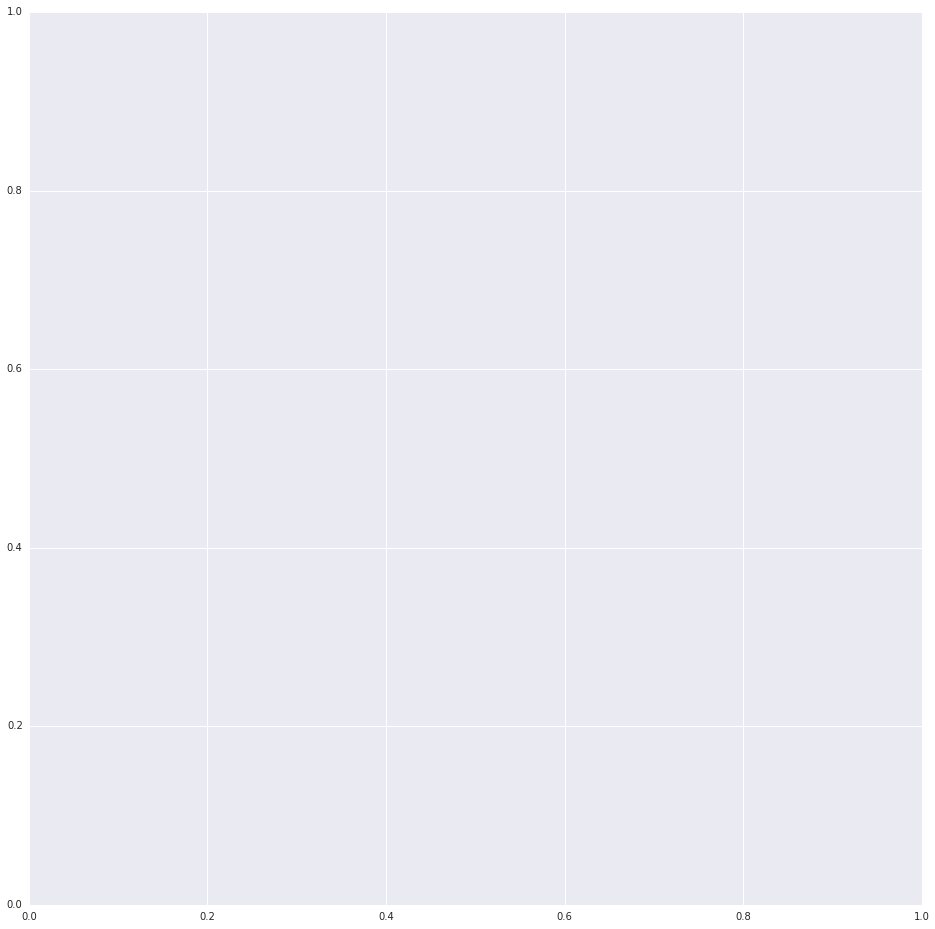

In [135]:
plt.imshow(rslt)

In [136]:
# takes set id, finds images, feeds in sets of 2 (always incl image 1) to im_align_orb()
def align_set_by_id(setid, isTrain=True, nFeatures=20000):
    """
    :param setid: Identifies set of images being worked
    :param isTrain: Flag inidating training data set
    :return:
    """
    train_path = './input/train_sm/'
    test_path = './input/test_sm/'

    if isTrain == True:
        image_path = train_path
        outputpath = "./process/train_sm/"
    else:
        image_path = test_path
        outputpath = "./process/test_sm/" 
    
    #result=list()
    """cvtColor is one of several color space processing functions. It converts
    an image from one color space to another. Here we're converting from BGR to RGB."""
    for frm in [1, 2, 3, 4, 5]:
        
        for to in [1, 2, 3, 4, 5]:
            
            if frm == to: 
                next
            else:
                fn1 = image_path + "set" + str(setid) + "_" + str(frm) + ".jpeg"
                fn2 = image_path + "set" + str(setid) + "_" + str(to) + ".jpeg"
                
                im, H = im_align_brisk(fn1, fn2, nFeatures)
                
                idx = outputpath + "set" + str(setid) + "_" + str(frm) + "_" + str(to) + ".jpeg"
                cv2.imwrite(idx, im)
                
                homo = pd.DataFrame([[idx, H.ravel()]])
                #result.append(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
            
                if frm ==1 and to == 2:
                    homo_blk = homo
                else:
                    homo_blk = homo_blk.append(homo)
                print(homo_blk)
    
    return homo_blk

Functions below use align_set_by_id() function to align all images for specified set. Please note, here I use ORB feature detector which has one parameter nFeatures. It means the max number of features to query. According to my experiment, for current train and test images, you'd better set it to 15000~20000 to get better balance between quality and speed.

In [137]:
sethomos=align_set_by_id(4, nFeatures=15000)

                                  0  \
0  ./process/train_sm/set4_1_2.jpeg   

                                                   1  
0  [0.966270779245, -0.222897778654, 278.26649168...  
                                  0  \
0  ./process/train_sm/set4_1_2.jpeg   
0  ./process/train_sm/set4_1_3.jpeg   

                                                   1  
0  [0.966270779245, -0.222897778654, 278.26649168...  
0  [1.21770807819, -0.47571701298, 1004.53986192,...  
                                  0  \
0  ./process/train_sm/set4_1_2.jpeg   
0  ./process/train_sm/set4_1_3.jpeg   
0  ./process/train_sm/set4_1_4.jpeg   

                                                   1  
0  [0.966270779245, -0.222897778654, 278.26649168...  
0  [1.21770807819, -0.47571701298, 1004.53986192,...  
0  [1.34952861684, 0.0798681653263, -594.14069353...  
                                  0  \
0  ./process/train_sm/set4_1_2.jpeg   
0  ./process/train_sm/set4_1_3.jpeg   
0  ./process/train_sm/set4_1_4.jpe

0     ./process/train_sm/set4_1_2.jpeg
1     ./process/train_sm/set4_1_3.jpeg
2     ./process/train_sm/set4_1_4.jpeg
3     ./process/train_sm/set4_1_5.jpeg
4     ./process/train_sm/set4_2_1.jpeg
5     ./process/train_sm/set4_2_3.jpeg
6     ./process/train_sm/set4_2_4.jpeg
7     ./process/train_sm/set4_2_5.jpeg
8     ./process/train_sm/set4_3_1.jpeg
9     ./process/train_sm/set4_3_2.jpeg
10    ./process/train_sm/set4_3_4.jpeg
11    ./process/train_sm/set4_3_5.jpeg
12    ./process/train_sm/set4_4_1.jpeg
13    ./process/train_sm/set4_4_2.jpeg
14    ./process/train_sm/set4_4_3.jpeg
15    ./process/train_sm/set4_4_5.jpeg
16    ./process/train_sm/set4_5_1.jpeg
17    ./process/train_sm/set4_5_2.jpeg
18    ./process/train_sm/set4_5_3.jpeg
19    ./process/train_sm/set4_5_4.jpeg
Name: 0, dtype: object


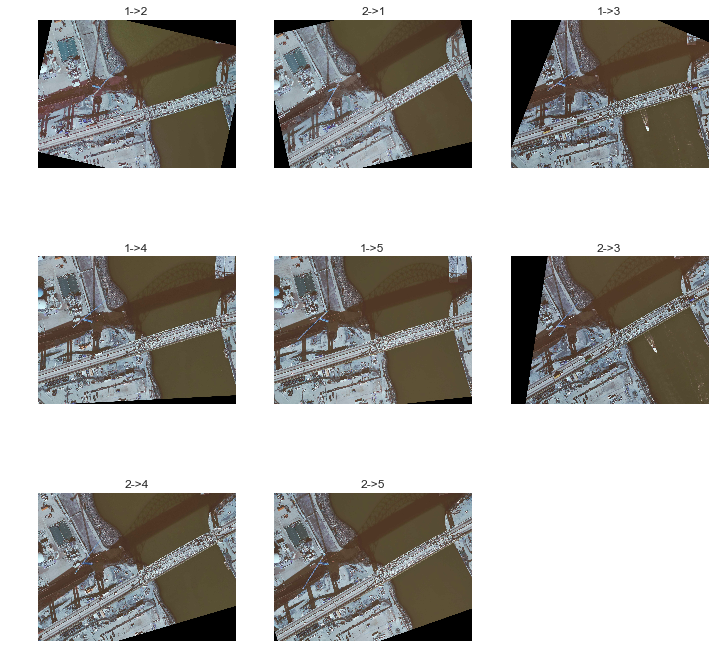

In [147]:
#sethomos = sethomos.reset_index(drop=True)
prnt = sethomos[0]

plt.figure(figsize=(12, 12))

plt.subplot(331).set_title('1->2'), plt.imshow(cv2.imread(prnt[0])),plt.axis('off')
plt.subplot(332).set_title('2->1'), plt.imshow(cv2.imread(prnt[4])),plt.axis('off')
plt.subplot(333).set_title('1->3'), plt.imshow(cv2.imread(prnt[1])),plt.axis('off')
plt.subplot(334).set_title('1->4'), plt.imshow(cv2.imread(prnt[2])),plt.axis('off')
plt.subplot(335).set_title('1->5'), plt.imshow(cv2.imread(prnt[3])),plt.axis('off')
plt.subplot(336).set_title('2->3'), plt.imshow(cv2.imread(prnt[5])),plt.axis('off')
plt.subplot(337).set_title('2->4'), plt.imshow(cv2.imread(prnt[6])),plt.axis('off')
plt.subplot(338).set_title('2->5'), plt.imshow(cv2.imread(prnt[7])),plt.axis('off')
                                               
plt.show()

# Rotate, Flip, Shuffle

I have already defined another function align_all_set() so that we can align all sets in batch mode. In your local computer you can run this function to generate all aligned images (very slow).

See below:

In [ ]:
def align_all_set(path, isTrain=True):
    allfiles = os.listdir(path)
    allfiles = [os.path.basename(file) for file in allfiles if file.startswith('set')]
    allsets = np.unique([f.split("_")[0].replace("set", "") for f in allfiles])

    os.makedirs(path + "/output", exist_ok=True)

    for s in allsets:
        align_set_by_id(s, isTrain, nFeatures=20000)